# 1. 라이브러리 / 데이터 불러오기

## 1-1. 라이브러리 불러오기

In [206]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import seaborn as sns
from IPython.display import Image

import pandas as pd
import numpy as np
import os
import sys
import io

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [207]:
def extract_date(df):
    df.split('-')[1]
    df.split('-')[2].split(' ')[0]
    return df.split('-')[1]+df.split('-')[2].split(' ')[0]
df = pd.read_csv(r'./sensor04_pre_sensor.csv')
df['timestamp'] = df['timestamp'].apply(extract_date)
df = df.drop('Unnamed: 0',axis=1)
def ReLU(x):
    return x * (x > 0)
def extract_month(df):
    return int(df[0:2])
def extract_day(df):
    return int(df[2:])
df['month'] = df['timestamp'].apply(extract_month)
df['day'] = df['timestamp'].apply(extract_day)
df = df.drop('timestamp',axis=1)
def convert_month_to_categorical(df):
    if df < 3:
        return 1
    elif 3<=df and df <6:
        return 2
    elif 6<=df and df <9:
        return 3     
    else:
        return 4     
df['month_categorical'] = df['month'].apply(convert_month_to_categorical)
def label_manage(label):
    if label==0.5:
        return 1
    else:
        return label
df['operation']= df['operation'].apply(label_manage)


df.head(1)



,sensor_04,operation,month,day,month_categorical
0,0.792242,0.0,4,1,2


In [208]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,sensor_04,operation,month,day,month_categorical
sensor_04,1.000000,-0.916251,0.066421,0.021166,-0.004105
operation,-0.916251,1.000000,-0.061016,-0.031374,-0.007493
month,0.066421,-0.061016,1.000000,0.015898,0.866513
day,0.021166,-0.031374,0.015898,1.000000,0.004592
month_categorical,-0.004105,-0.007493,0.866513,0.004592,1.000000


In [209]:
df = df.drop('month',axis=1)

In [210]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,sensor_04,operation,day,month_categorical
sensor_04,1.000000,-0.916251,0.021166,-0.004105
operation,-0.916251,1.000000,-0.031374,-0.007493
day,0.021166,-0.031374,1.000000,0.004592
month_categorical,-0.004105,-0.007493,0.004592,1.000000


In [211]:
 # 측정데이터와 레이블(정답)을 분리
X = df.drop('operation',axis=1)
y = df['operation']
# print(y[-1:].reshape(-1))   # iloc으로 받아오면 numpy의 ndarray형이다.
#y = np.where(y == 'operation', 1, 0)
#y = y.ravel()   # 레이블을 1차원으로 변경하자.
print(X.shape, y.shape)


(220320, 3) (220320,)


In [212]:
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
220315    0.0
220316    0.0
220317    0.0
220318    0.0
220319    0.0
Name: operation, Length: 220320, dtype: float64

In [213]:
# 훈련셋과 테스트셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2022)

# 8. 결과 분석 및 해석

In [214]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

In [215]:
def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도 :{0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f}, F1 : {3: .4f}'.format(accuracy, precision, recall, f1))

In [216]:
from sklearn.ensemble import RandomForestClassifier

In [217]:
rf_cls = RandomForestClassifier(max_depth=3)

In [218]:
rf_cls = rf_cls.fit(X_train, y_train)
rf_prediction = rf_cls.predict(X_test)

In [219]:
get_clf_eval(y_test, rf_prediction)

오차 행렬
[[61251   553]
 [   77  4215]]
정확도 : 0.9905, 정밀도:  0.8840, 재현율:  0.9821, F1 :  0.9305


In [220]:
vae_x_tr = []
for xi,x in enumerate(np.asarray(X_train)):
    if y_train[xi]==1:
        vae_x_tr.append(x)
vae_x_test = []

for xi,x in enumerate(np.asarray(X_test)):
    if y_test[xi]==0:
        vae_x_test.append(x)

KeyError: 2

In [ ]:
#vae_x_train = df.loc[df['INSP']=='OK'].iloc[:, 1:5].values
vae_x_train = np.asarray(vae_x_tr)

In [ ]:
np.where(y_train==0)[0]

array([     0,      1,      2, ..., 154221, 154222, 154223], dtype=int64)

In [ ]:
y_train

176299    0.0
31719     0.0
37626     0.0
155023    0.0
140065    0.0
         ... 
177841    0.0
103024    0.0
147629    0.0
1244      0.0
86909     0.0
Name: operation, Length: 154224, dtype: float64

In [ ]:
vae_x_tr = []
vae_x_vaild = []
vae_x_test= []
arr_x_train = np.asarray(X_train)
arr_y_train = np.asarray(y_train)
for indice in np.where(y_train==0)[0]:
    vae_x_tr.append(arr_x_train[indice])
    
for indice in np.where(y_train==1)[0]:
    vae_x_vaild.append(arr_x_train[indice])

vae_x_train = np.asarray(vae_x_tr)
vae_x_vaild = np.asarray(vae_x_vaild)

vae_x_test = np.asarray(X_test)
vae_y_test = np.asarray(y_test)

In [ ]:
input_size =len(vae_x_train[0]) 
hidden_size = [8,64,256]
output_size =2
batch_size=256

In [266]:
## AutoEncoder 클래스 구현 
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VariationalAutoEncoder, self).__init__()
        ## initialize
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.Relu = nn.RReLU()
        ##오토인코더 구현
        
        self.fc_mu = nn.Linear(output_size,output_size)
        self.fc_var =nn.Linear(output_size,output_size)
        
        ## 인코더 부분
        self.input_en_layer = nn.Linear(input_size, hidden_size[0])
        self.bn1 = nn.BatchNorm1d(hidden_size[0])
        self.input_en_layer_2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.bn2 = nn.BatchNorm1d(hidden_size[1])
        self.input_en_layer_3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.bn3 = nn.BatchNorm1d(hidden_size[2])
        self.output_en_layer = nn.Linear(hidden_size[2], output_size)
        
        #log_var = 
        
        ## 디코더 부분
        self.input_dic_layer = nn.Linear(output_size, hidden_size[2])
        self.input_dic_layer_3 = nn.Linear(hidden_size[2], hidden_size[1])
        self.input_dic_layer_2 = nn.Linear(hidden_size[1], hidden_size[0])
        
        self.output_dic_layer = nn.Linear(hidden_size[0], input_size)
        
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        self.mu = 0
        self.z = 0
        self.log_var = 0
        
        
    def encode(self,inputs):
        x = self.bn1(self.input_en_layer(inputs))
        x = self.Relu(x)
        
        x = self.bn2(self.input_en_layer_2(x))
        x = self.Relu(x)
        x = self.bn3(self.input_en_layer_3(x))
        x = self.Relu(x)

        output = self.output_en_layer(x) 
        
        return output
    
    def decode(self,output):
        output = self.input_dic_layer(output)
        output = self.Relu(output)
        output = (self.input_dic_layer_3(output))
        output = self.Relu(output)
        output = (self.input_dic_layer_2(output))
        output = self.Relu(output)
        output = self.output_dic_layer(output)
        
        return output
    
    def gaussian_likelihood(self,x_hat,x):
        scale=  torch.exp(torch.tensor(self.log_scale))
        mean = x_hat
        dist = torch.distributions.Normal(mean,scale)
        
        log_pxz = dist.log_prob(x)
        
        return log_pxz.sum(dim=(1))
        
 
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)

        # sum over last dim to go from single dim distribution to multi-dim
        kl = kl.sum(-1)
        return kl
    
    
    def forward(self, inputs): 
        output = self.encode(inputs)
        self.mu = self.fc_mu(output)
        self.log_var = self.fc_var(output)
        std = torch.exp(self.log_var/2)
        q = torch.distributions.Normal(self.mu,std)
        z = q.rsample()
        x_hat = self.decode(z)
        
        recon_loss = self.gaussian_likelihood(x_hat,inputs)
        kl =  self.kl_divergence(z,self.mu,std)
        
        elbo = (kl - recon_loss)
        elbo = elbo.mean()
        
        return elbo

    def predict(self, inputs): 
        output = self.encode(inputs)
        self.mu = self.fc_mu(output)
        self.log_var = self.fc_var(output)
        std = torch.exp(self.log_var/2)
        q = torch.distributions.Normal(self.mu,std)
        z = q.rsample()
        x_hat = self.decode(z)
        
        recon_loss = self.gaussian_likelihood(x_hat,inputs)
        kl =  self.kl_divergence(z,self.mu,std)
        
        elbo = (kl - recon_loss)

        
        return elbo
    

In [267]:
MSELoss = nn.MSELoss()
## 매개변수 조정 방식으로 Adam사용
optimizer = torch.optim.Adam
VAE = VariationalAutoEncoder(input_size,hidden_size, output_size)
optim = optimizer(VAE.parameters())

In [357]:
Adam = optimizer(VAE.parameters(), lr =0.001,weight_decay=0.00005)
## 배치 학습을 시키기 위한 데이터 변환
data_iter = DataLoader(vae_x_train, batch_size =batch_size, shuffle =True)
## 에포크 학습
vae_train_loss =[]
VAE.train()
for ep in range(1, 100 +1):
    running_loss =0.0
    for x in data_iter:
        ## 매개변수 0으로 초기화
        Adam.zero_grad()
        x = torch.tensor(x,dtype=torch.float32)
        loss = VAE.forward(x)
        #loss += MSELoss(output,x)
        loss.backward()
        
        
        Adam.step()
        running_loss += loss.item()
    vae_train_loss.append(running_loss/batch_size)
    ## 각 에포크마다 손실 값 표기
    if ep%10==0:
        print("epoch: {}, loss: {:.2f}".format(ep, running_loss))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23100\1895833182.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23100\2297523557.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale=  torch.exp(torch.tensor(self.log_scale))


epoch: 10, loss: 3074.83
epoch: 20, loss: 3074.30
epoch: 30, loss: 3075.46
epoch: 40, loss: 3072.07
epoch: 50, loss: 3076.38
epoch: 60, loss: 3076.51
epoch: 70, loss: 3075.72
epoch: 80, loss: 3074.90
epoch: 90, loss: 3072.17
epoch: 100, loss: 3071.36


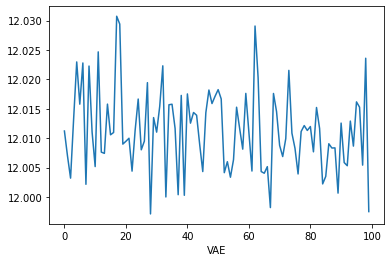

In [358]:
plt.xlabel('VAE')
plt.plot(vae_train_loss)

In [359]:
VAE.eval()

VariationalAutoEncoder(
  (Relu): RReLU(lower=0.125, upper=0.3333333333333333)
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
  (input_en_layer): Linear(in_features=3, out_features=8, bias=True)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_en_layer_2): Linear(in_features=8, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_en_layer_3): Linear(in_features=32, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_en_layer): Linear(in_features=64, out_features=2, bias=True)
  (input_dic_layer): Linear(in_features=2, out_features=64, bias=True)
  (input_dic_layer_3): Linear(in_features=64, out_features=32, bias=True)
  (input_dic_layer_2): Linear(in_features=32, out_features=8, bias=True)
  (output_dic_layer): Linear(in

In [360]:
VAE.forward(torch.tensor(vae_x_train[0:1],dtype=torch.float32))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23100\2297523557.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale=  torch.exp(torch.tensor(self.log_scale))


tensor(5.9988, grad_fn=<MeanBackward0>)

In [393]:
## 훈련세트의 손실값 이용한 임계값 정의
train_loss_chart = []
test_iter = DataLoader(vae_x_train, batch_size =batch_size, shuffle =True)
for data in test_iter:
    data = torch.tensor(data,dtype=torch.float32)
    loss = VAE.forward(data)
    #loss += MSELoss(output,data)
    train_loss_chart.append(loss.item())
    
threshold = np.mean(train_loss_chart) + np.std(train_loss_chart)*10
print("Threshold :", threshold)  #결과는 아래에서 확인 가능하다.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23100\4068705557.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data,dtype=torch.float32)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23100\2297523557.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale=  torch.exp(torch.tensor(self.log_scale))


Threshold : 5.827268189069642


In [394]:
## 훈련세트의 손실값 이용한 임계값 정의
test_loss_chart = []
test_iter = DataLoader(vae_x_test, batch_size =batch_size)
y_pred = []
for data in test_iter:
    #data = (torch.unsqueeze(data,0))
    data = torch.tensor(data,dtype=torch.float32)
    #print(data.shape)
    loss = VAE.predict(data)
    #loss += MSELoss(output,data)
    for pred_loss in loss:
        pred = 0
        if pred_loss >threshold:
            pred = 1     
        y_pred.append(pred)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23100\3268712293.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data,dtype=torch.float32)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23100\2297523557.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale=  torch.exp(torch.tensor(self.log_scale))


In [395]:
accuracy_score(y_pred,y_test)

0.7986867586540789

In [396]:
f1_score(y_pred,y_test)

0.2565649793272992

In [397]:
y_test

2537      0.0
168862    0.0
130862    1.0
105410    0.0
218003    0.0
         ... 
103142    0.0
1650      0.0
170925    0.0
56347     0.0
114430    0.0
Name: operation, Length: 66096, dtype: float64

In [398]:
y_pred

[0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
